In [1]:
# coding:utf8

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [3]:
import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

定义模型

In [4]:
class TorchModel(nn.Module):
    def __init__(self, input_size, num_classes=5):
        super(TorchModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)  # 线性层
        # self.activation = torch.sigmoid  # nn.Sigmoid() sigmoid归一化函数 -- 多分类不需要 sigmoid 激活函数
        # self.loss = nn.functional.mse_loss  # loss函数采用均方差损失
        self.loss = nn.functional.cross_entropy  # 交叉熵损失函数

    # 当输入真实标签，返回loss值；无真实标签，返回预测值
    def forward(self, x, y=None):
        y_pred = self.linear(x)  # (batch_size, input_size) -> (batch_size, num_classes)
        if y is not None:
            return self.loss(y_pred, y)  # 预测值和真实值计算损失
        else:
            return y_pred  # 输出预测结果

定义生成测试样本

In [5]:
# 生成一个样本, 样本的生成方法，代表了我们要学习的规律
# 随机生成一个5维向量，如果第一个值大于第五个值，认为是正样本，反之为负样本
def build_sample():
    x = np.random.random(5)
    # if x[0] > x[4]:
    #     return x, 1
    # else:
    #     return x, 0
    return x, np.argmax(x) # 输出测试数据、和最大值标签


# 随机生成一批样本
# 正负样本均匀生成
def build_dataset(total_sample_num):
    X = []
    Y = []
    for i in range(total_sample_num):
        x, y = build_sample()
        X.append(x)
        Y.append(y)
    # print(X)
    # print(Y)
    return torch.FloatTensor(X), torch.LongTensor(Y)

定义评估函数

In [6]:
# 测试代码
# 用来测试每轮模型的准确率
def evaluate(model):
    model.eval()
    test_sample_num = 100
    x, y = build_dataset(test_sample_num)
    # print("本次评估生成的样本中, 各个类别的数量为: ", [sum(y == i) for i in range(5)]) # 5分类 # 日志, 需要观察的时候打开
    correct, wrong = 0, 0
    with torch.no_grad():
        y_pred = model(x)  # 模型预测 model.forward(x)
        pred_cls = torch.argmax(y_pred, dim=1)
        correct = (pred_cls == y).sum().item()
        wrong = test_sample_num - correct

        # for y_p, y_t in zip(y_pred, y):  # 与真实标签进行对比
        #     if float(y_p) < 0.5 and int(y_t) == 0:
        #         correct += 1  # 负样本判断正确
        #     elif float(y_p) >= 0.5 and int(y_t) == 1:
        #         correct += 1  # 正样本判断正确
        #     else:
        #         wrong += 1
    # print("正确预测个数：%d, 正确率：%f" % (correct, correct / (correct + wrong))) # 日志, 需要观察的时候打开
    return correct / (correct + wrong)

训练测试方法

In [10]:
def main():
    # 配置参数
    epoch_num = 100  # 训练轮数
    batch_size = 20  # 每次训练样本个数
    train_sample = 5000  # 每轮训练总共训练的样本总数
    input_size = 5  # 输入向量维度
    learning_rate = 0.001  # 学习率
    num_classes = 5 # 设置为5个分类
    # 建立模型
    model = TorchModel(input_size, num_classes)
    # 选择优化器
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log = []
    # 创建训练集，正常任务是读取训练集
    train_x, train_y = build_dataset(train_sample)
    # 训练过程
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch_index in range(train_sample // batch_size):
            #取出一个batch数据作为输入   train_x[0:20]  train_y[0:20] train_x[20:40]  train_y[20:40]
            x = train_x[batch_index * batch_size : (batch_index + 1) * batch_size]
            y = train_y[batch_index * batch_size : (batch_index + 1) * batch_size]
            loss = model(x, y)  # 计算loss  model.forward(x,y)
            loss.backward()  # 计算梯度
            optim.step()  # 更新权重
            optim.zero_grad()  # 梯度归零
            watch_loss.append(loss.item())
        # print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss))) # 日志, 需要的时候打开
        acc = evaluate(model)  # 测试本轮模型结果
        log.append([acc, float(np.mean(watch_loss))])
    # 保存模型
    torch.save(model.state_dict(), "model_multi.bin")
    # 画图
    # print(log)
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")  # 画acc曲线
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")  # 画loss曲线
    plt.legend()
    plt.show()
    return

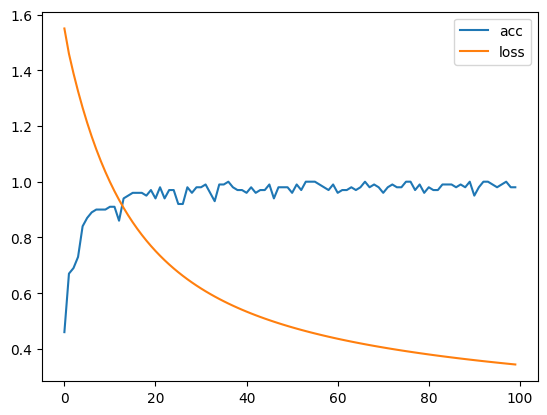

In [11]:
main()

数据预测

In [9]:
# 使用训练好的模型做预测
def predict(model_path, input_vec):
    input_size = 5
    num_classes = 5 # 和训练使用相同的分类数目
    model = TorchModel(input_size, num_classes)
    model.load_state_dict(torch.load(model_path, weights_only=True))  # 加载训练好的权重
    print(model.state_dict()) # 输出模型 w、b 参数

    model.eval()  # 测试模式
    with torch.no_grad():  # 不计算梯度
        result = model.forward(torch.FloatTensor(input_vec))  # 模型预测
        probs = torch.softmax(result, dim=1)
        probs_cls = torch.argmax(probs, dim=1)
    for vec, cls, prob in zip(input_vec, probs_cls, probs):
        print("输入：%s, 预测类别：%d, 概率分布：%s" % (vec, cls.item(), prob.numpy()))  # 打印结果

test_vec = [[0.07889086,0.15229675,0.31082123,0.03504317,0.88920843],
            [0.74963533,0.5524256,0.95758807,0.95520434,0.84890681],
            [0.90797868,0.67482528,0.13625847,0.34675372,0.19871392],
            [0.99349776,0.59416669,0.92579291,0.41567412,0.1358894]]
predict("model_multi.bin", test_vec)

OrderedDict({'linear.weight': tensor([[ 7.1739, -2.9054, -2.9113, -2.8540, -2.8773],
        [-3.1815,  7.6638, -3.0686, -3.1162, -2.9659],
        [-2.8814, -2.6886,  7.2160, -2.9308, -2.8267],
        [-3.0486, -2.7675, -3.1008,  7.4079, -2.8887],
        [-2.9499, -2.7869, -2.9996, -3.0059,  7.4168]]), 'linear.bias': tensor([-0.1598, -0.0814, -0.2486, -0.0633, -0.1873])})
输入：[0.07889086, 0.15229675, 0.31082123, 0.03504317, 0.88920843], 预测类别：4, 概率分布：[2.4453684e-04 5.0960138e-04 2.5410657e-03 1.6417050e-04 9.9654061e-01]
输入：[0.74963533, 0.5524256, 0.95758807, 0.95520434, 0.84890681], 预测类别：2, 概率分布：[0.04827421 0.00473459 0.4187991  0.40239352 0.12579863]
输入：[0.90797868, 0.67482528, 0.13625847, 0.34675372, 0.19871392], 预测类别：0, 概率分布：[9.0646857e-01 8.8937700e-02 4.0672548e-04 3.4818032e-03 7.0518185e-04]
输入：[0.99349776, 0.59416669, 0.92579291, 0.41567412, 0.1358894], 预测类别：0, 概率分布：[6.3806653e-01 9.6021555e-03 3.5046399e-01 1.7672825e-03 9.9990117e-05]
